In [33]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import seaborn as sns
#from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from glob import glob
from collections import defaultdict
import scipy
from sklearn.metrics import roc_auc_score

import matplotlib

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'13-mer':"#F0E442",'PhyloP-100way':"#0072B2",'PhyloP-241way':"#D55E00",'NT-MS-v2-500M':"#009E73"}

In [2]:
#data_dir = '/s/project/mll/sergey/effect_prediction/MLM/motif_predictions/split_75_25/'
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/motif_predictions/split_75_25/'

In [3]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

In [4]:
motif_len = 5 #5 or 6

In [5]:
table_motifs = pd.read_excel(data_dir + '../../dominguez_2018/1-s2.0-S1097276518303514-mmc4.xlsx',
             sheet_name = motif_len-4, skiprows=1)

selected_motifs = []

for col_idx in range(0,len(table_motifs.columns),2):
    motif = table_motifs.iloc[:,col_idx:col_idx+1]
    stepwise_r = table_motifs.iloc[:,col_idx+1:col_idx+2]
    selected_motifs.extend(motif[(stepwise_r>0.1).values].values.tolist())

selected_motifs = np.unique(np.array(selected_motifs).flatten())

In [6]:
len(selected_motifs)

153

In [7]:
eclip_pos_intervals = pd.read_pickle(data_dir + '../../eCLIP/eCLIP_intervals_3UTR.df')

In [13]:
models = { 'Species-agnostic':'../species_agnostic/probas.pickle','Species-aware':'../species_aware/probas.pickle', 
          'DNABERT': '../dnabert/default/*.pickle', '13-mer':'../K-mer/13_mer.pickle',
          'PhyloP-100way': '../../PhyloP/PhyloP100_3UTR.pickle' ,'PhyloP-241way': '../../PhyloP/PhyloP241_3UTR.pickle', 'NT-MS-v2-500M': 'ntrans/NT-MS-v2-500M/*.pickle'}

In [14]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [15]:
def get_model(glob_path):
    res = {}
    for probas_file in glob(glob_path):
        #print(probas_file)
        with open(probas_file, 'rb') as f:
            model_probas = pickle.load(f)
            if len(model_probas)==2:
                res.update({model_probas[0]:model_probas[1]})
            else:
                res.update(dict(model_probas))
    return res

In [16]:
res = {}

for model, model_path in models.items():
    res[model] = get_model(data_dir + model_path)
    print(f'{model} loaded, {len(res[model])} sequences')

Species-agnostic loaded, 18134 sequences
Species-aware loaded, 18134 sequences
DNABERT loaded, 18134 sequences
13-mer loaded, 18134 sequences
PhyloP-100way loaded, 18178 sequences
PhyloP-241way loaded, 18178 sequences
NT-MS-v2-500M loaded, 4245 sequences


In [17]:
motifs_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    for motif_start in range(0,len(seq)-motif_len):
        motif_end = motif_start+motif_len
        motif = seq[motif_start:motif_end]
        motif_mapping = [list(range(motif_len)),list(map(lambda x:mapping[x],motif))]
        for model in models:
            if seq_name in res[model]:
                if not 'PhyloP' in model:
                    avg_target_prob = np.mean(res[model][seq_name][motif_start:motif_end][motif_mapping[0], motif_mapping[1]])
                else:
                    avg_target_prob = np.mean(res[model][seq_name][motif_start:motif_end])
                motifs_df.append((model,seq_name,motif_start,motif,avg_target_prob))

100%|██████████| 4534/4534 [08:09<00:00,  9.25it/s]


In [18]:
motifs_df = pd.DataFrame(motifs_df,columns = ['model','seq_name','motif_start','motif','avg_target_prob'])

In [21]:
R = 2500 #conservation distance

In [23]:
conservation_csv = data_dir + '../species_aware/conservation_k5_new.csv.gz'

conservation_df = pd.read_csv(conservation_csv)

conservation_df['mobility'] = conservation_df[f'Nmatches_{R}'] - conservation_df.Nmatches_0

In [25]:
motifs_df = motifs_df.merge(conservation_df, how='left')

In [26]:
motifs_df['functional'] = (motifs_df.motif.isin(selected_motifs))&(motifs_df.is_eCLIP)

In [167]:
mobility_pct = 0

In [168]:
motifs_df['valid_mobility'] = True
if mobility_pct>0:
    motifs_df.loc[motifs_df.L_nearest<2*R,'valid_mobility'] = False

In [169]:
((motifs_df.functional)&(motifs_df.valid_mobility)).sum()

5284647

In [170]:
((~motifs_df.functional)&(motifs_df.valid_mobility)).sum()

49502050

In [171]:
mobility_thr = np.nanpercentile(motifs_df[(motifs_df.functional)&(motifs_df.valid_mobility)].mobility, mobility_pct)

In [172]:
mobility_thr

0.0

In [173]:
models = ('DNABERT', 'NT-MS-v2-500M', '13-mer', 'Species-agnostic', 'Species-aware', 'PhyloP-100way', 'PhyloP-241way', )

In [180]:
odds_ratios = []

for model in models:

    df = motifs_df[(motifs_df.model==model)&(motifs_df.valid_mobility)]
    
    model_pct_thr_top = np.nanpercentile(df.avg_target_prob,90)
    N_nonfunctional_top = ((df.avg_target_prob>model_pct_thr_top)&(~df.functional)).sum()
    N_functional_mobile_top = ((df.avg_target_prob>model_pct_thr_top)&(df.functional)&(df.mobility>=mobility_thr)).sum()

    model_pct_thr_bottom = np.nanpercentile(df.avg_target_prob,10)
    N_nonfunctional_bottom = ((df.avg_target_prob<model_pct_thr_bottom)&(~df.functional)).sum()
    N_functional_mobile_bottom = ((df.avg_target_prob<model_pct_thr_bottom)&(df.functional)&(df.mobility>=mobility_thr)).sum()
    
    #N_strong_mobile_motifs = ((selected_motifs_df.mobility>mobility_thr)&(selected_motifs_df.model==model)).sum()
    #strong_mobile_motifs_top = (selected_motifs_df[(selected_motifs_df.mobility>mobility_thr)&(selected_motifs_df.model==model)].avg_target_prob>model_pct_thr_top).sum()

    contig_table = [[N_functional_mobile_top,N_nonfunctional_top],[N_functional_mobile_bottom,N_nonfunctional_bottom]]
    
    fisher_test = scipy.stats.fisher_exact(contig_table)
    
    OR = fisher_test.statistic
    CI_95_high = np.exp(np.log(OR)+1.96*np.sqrt((1/np.array(contig_table)).sum()))
    CI_95_low = np.exp(np.log(OR)-1.96*np.sqrt((1/np.array(contig_table)).sum()))

    auc = roc_auc_score(df.functional[~df.avg_target_prob.isna()],df.avg_target_prob[~df.avg_target_prob.isna()])
    
    print(model,contig_table, fisher_test, auc)
    
    odds_ratios.append((model, OR, CI_95_low, CI_95_high, fisher_test.pvalue, auc))

DNABERT [[67613, 721613], [56388, 732839]] SignificanceResult(statistic=1.217720843760617, pvalue=4.158662613547437e-242) 0.56764213412678
NT-MS-v2-500M [[61294, 682014], [59686, 683622]] SignificanceResult(statistic=1.029362233440054, pvalue=1.4316268467197937e-06) 0.5434309967725521
13-mer [[98822, 690405], [49555, 739672]] SignificanceResult(statistic=2.1364926821634236, pvalue=0.0) 0.5726590679502471
Species-agnostic [[107522, 681705], [50665, 738562]] SignificanceResult(statistic=2.299215965725833, pvalue=0.0) 0.6006490980832361
Species-aware [[109662, 679565], [53814, 735413]] SignificanceResult(statistic=2.2052670445674623, pvalue=0.0) 0.5976184987137468
PhyloP-100way [[117165, 671165], [64274, 723901]] SignificanceResult(statistic=1.9661309703277183, pvalue=0.0) 0.5693766166637085
PhyloP-241way [[111007, 677371], [65933, 722367]] SignificanceResult(statistic=1.7954727877571717, pvalue=0.0) 0.5647202955070073


In [181]:
odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR','CI_95_low','CI_95_high', 'pvalue', 'roc_auc'])

In [182]:
odds_ratios['padj'] = odds_ratios.pvalue*len(models)

In [183]:
#odds_ratios['padj'] =  scipy.stats.false_discovery_control(odds_ratios.pvalue)

In [184]:
odds_ratios.set_index('model', inplace=True)

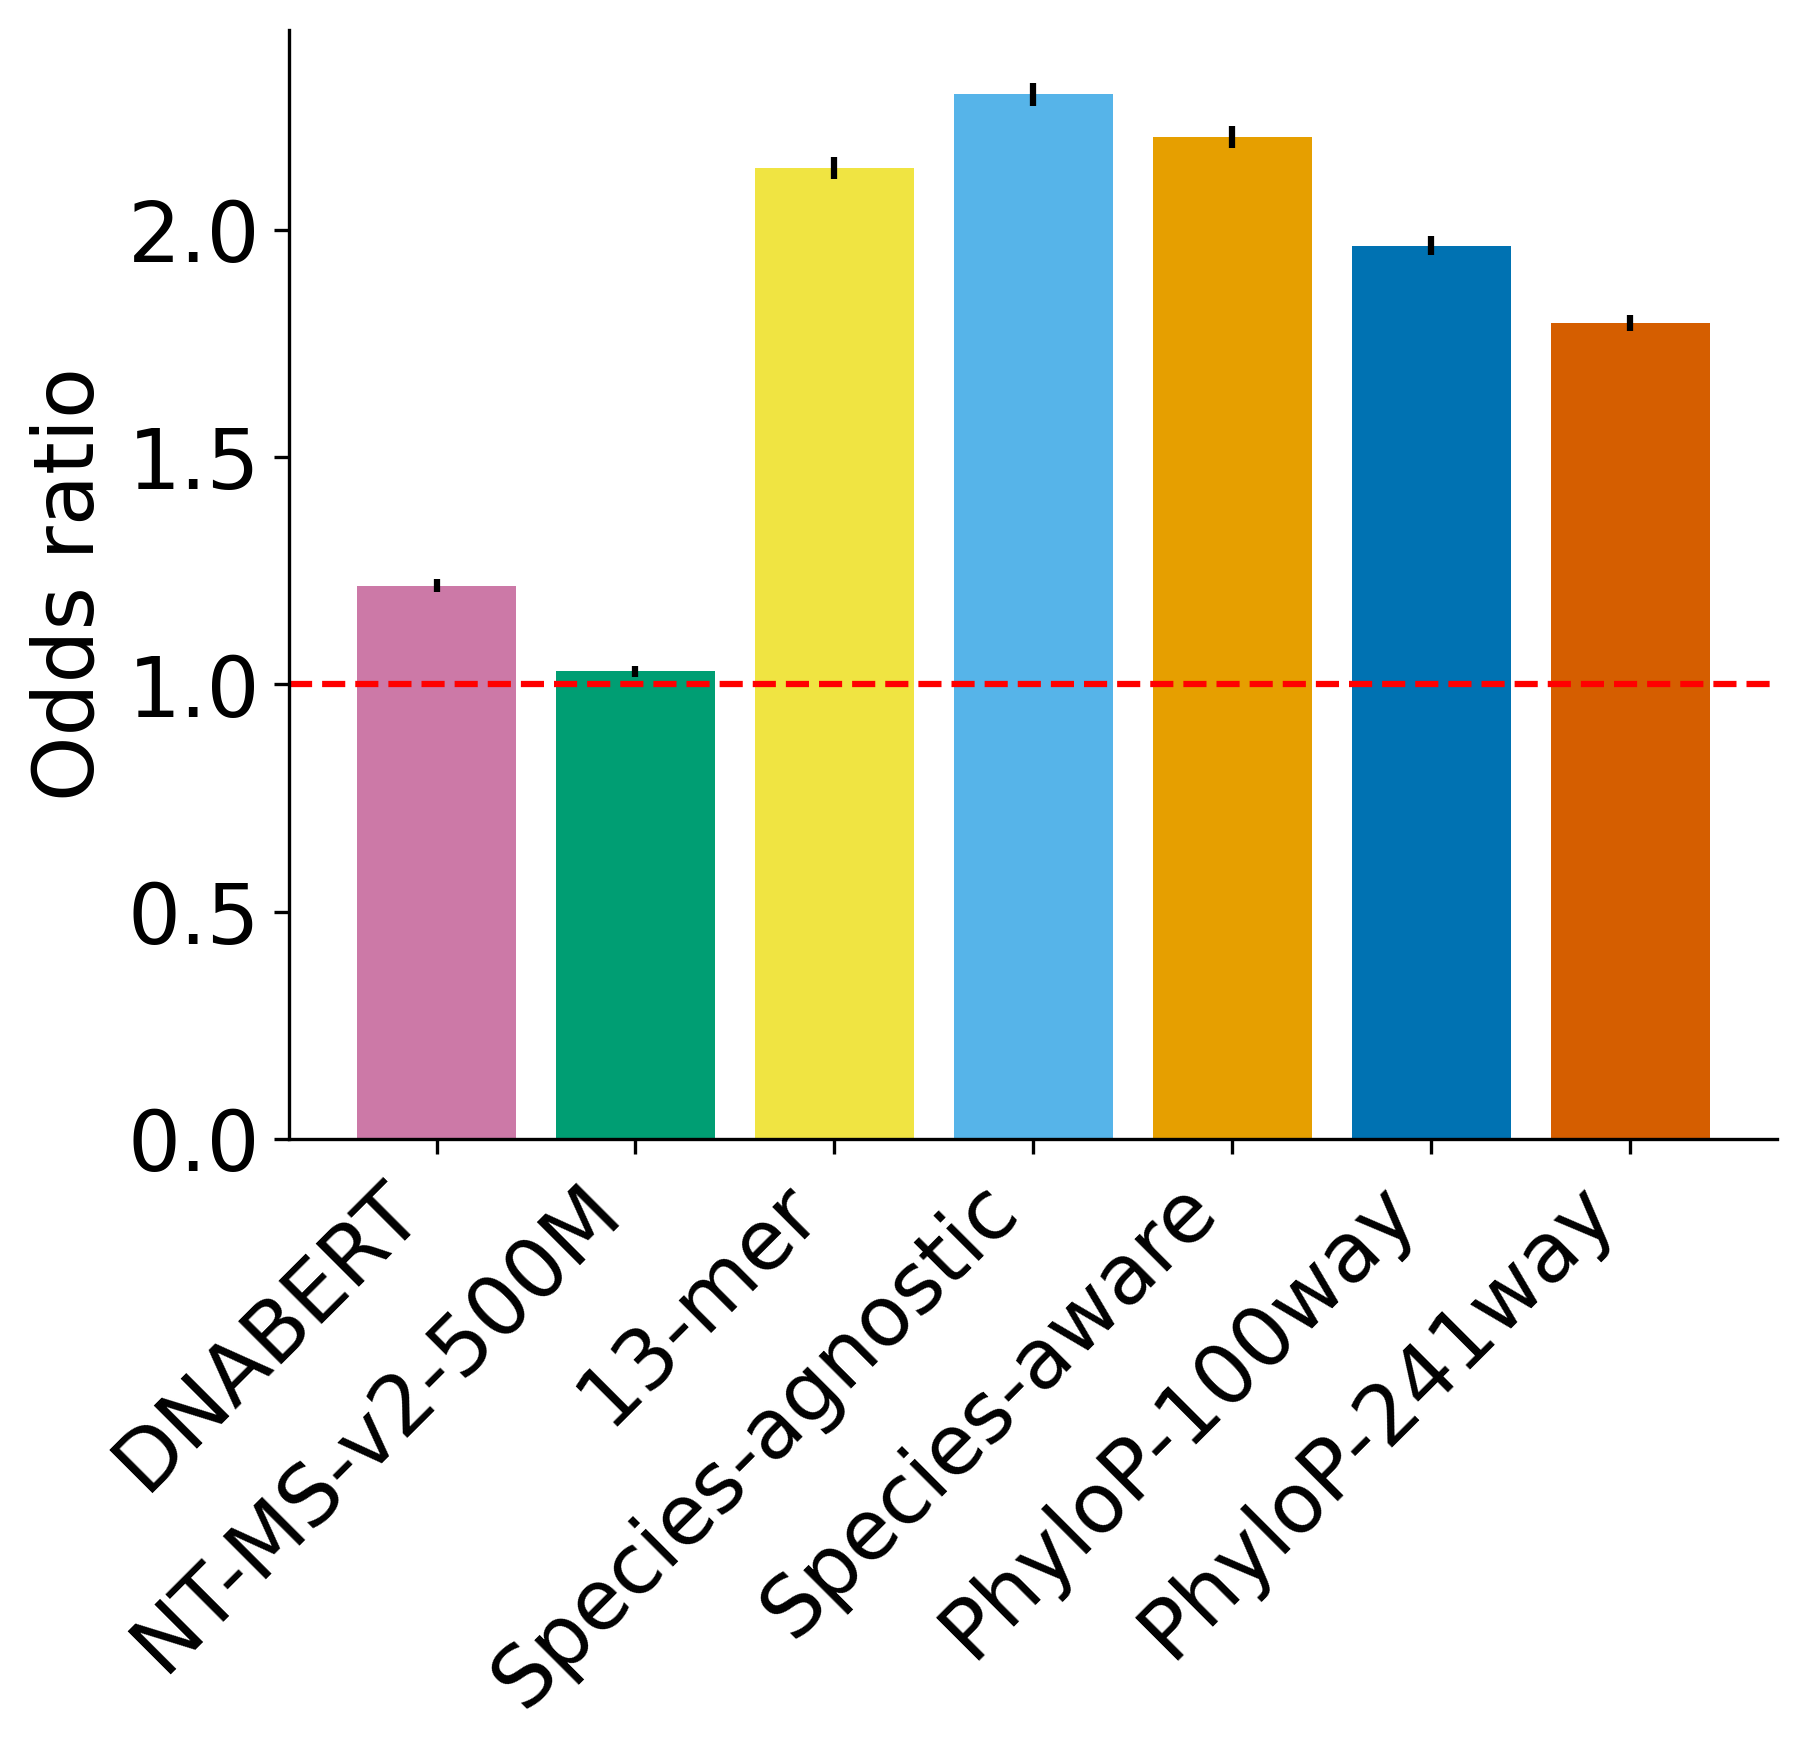

In [185]:
fig, ax = plt.subplots(dpi=300)


ax.bar(odds_ratios.index, odds_ratios.OR, yerr=[odds_ratios.OR-odds_ratios.CI_95_low,odds_ratios.CI_95_high-odds_ratios.OR], color=odds_ratios.index.map(model_colors))

plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if odds_ratios.OR.max()>50:
    ax.set_yscale('log')

ax.axhline(1,0,len(models),color='r', linestyle='--')

for model_idx, model in enumerate(odds_ratios.index):
    padj = odds_ratios.loc[model,'padj']
    if padj<1e-4:
        stars='****'
    elif padj<1e-3:
        stars='***'
    elif padj<1e-2:
        stars = '**'
    elif padj<5e-2:
        stars = '*'
    else:
        stars = 'ns'
    #if stars == 'ns':
        #ax.text(model_idx, odds_ratios.loc[model].OR+odds_ratios.OR.max()*0.03, f'{stars}',ha='center', va='center')


(0.0, 299.0)

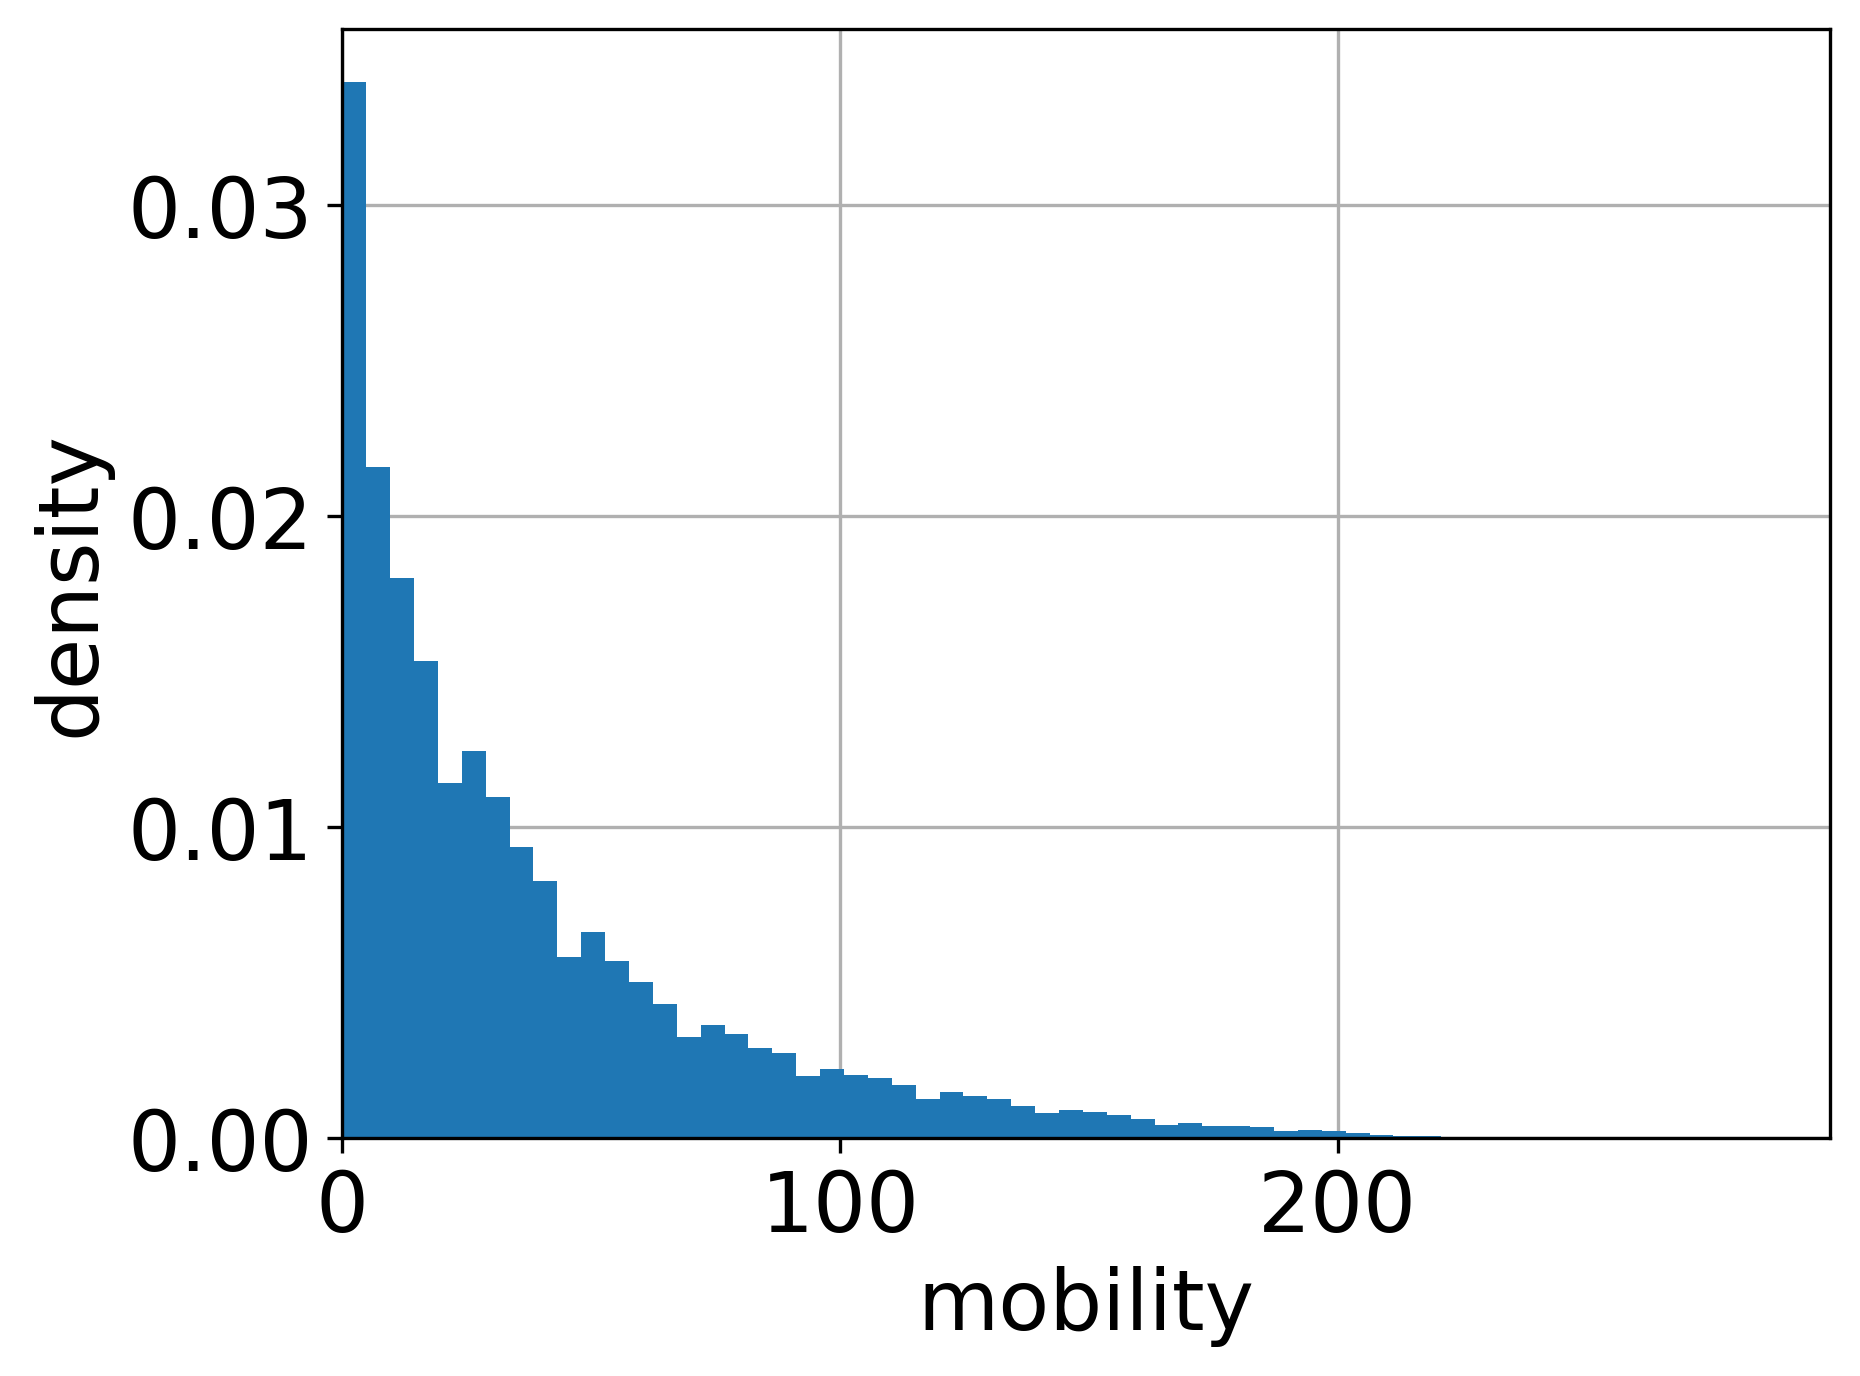

In [76]:
fig, ax = plt.subplots(dpi=300)


motifs_df[(motifs_df.functional)&(motifs_df.valid_mobility)].drop_duplicates(subset=['seq_name','motif_start']).mobility.hist(ax=ax, density=True, bins=50)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('density')
ax.set_xlabel('mobility')
ax.set_xlim([0,299])

#if mobility_pct>0:
#    ylims = ax.get_ylim()
#    ax.vlines(x=mobility_thr,ymin=0,ymax=ylims[1], color='r', linestyle='--')
#    ax.set_ylim(ylims)
#    ax.text(x=mobility_thr, y=ylims[1]*0.9, s= f' {mobility_pct}th pct.',color='r')

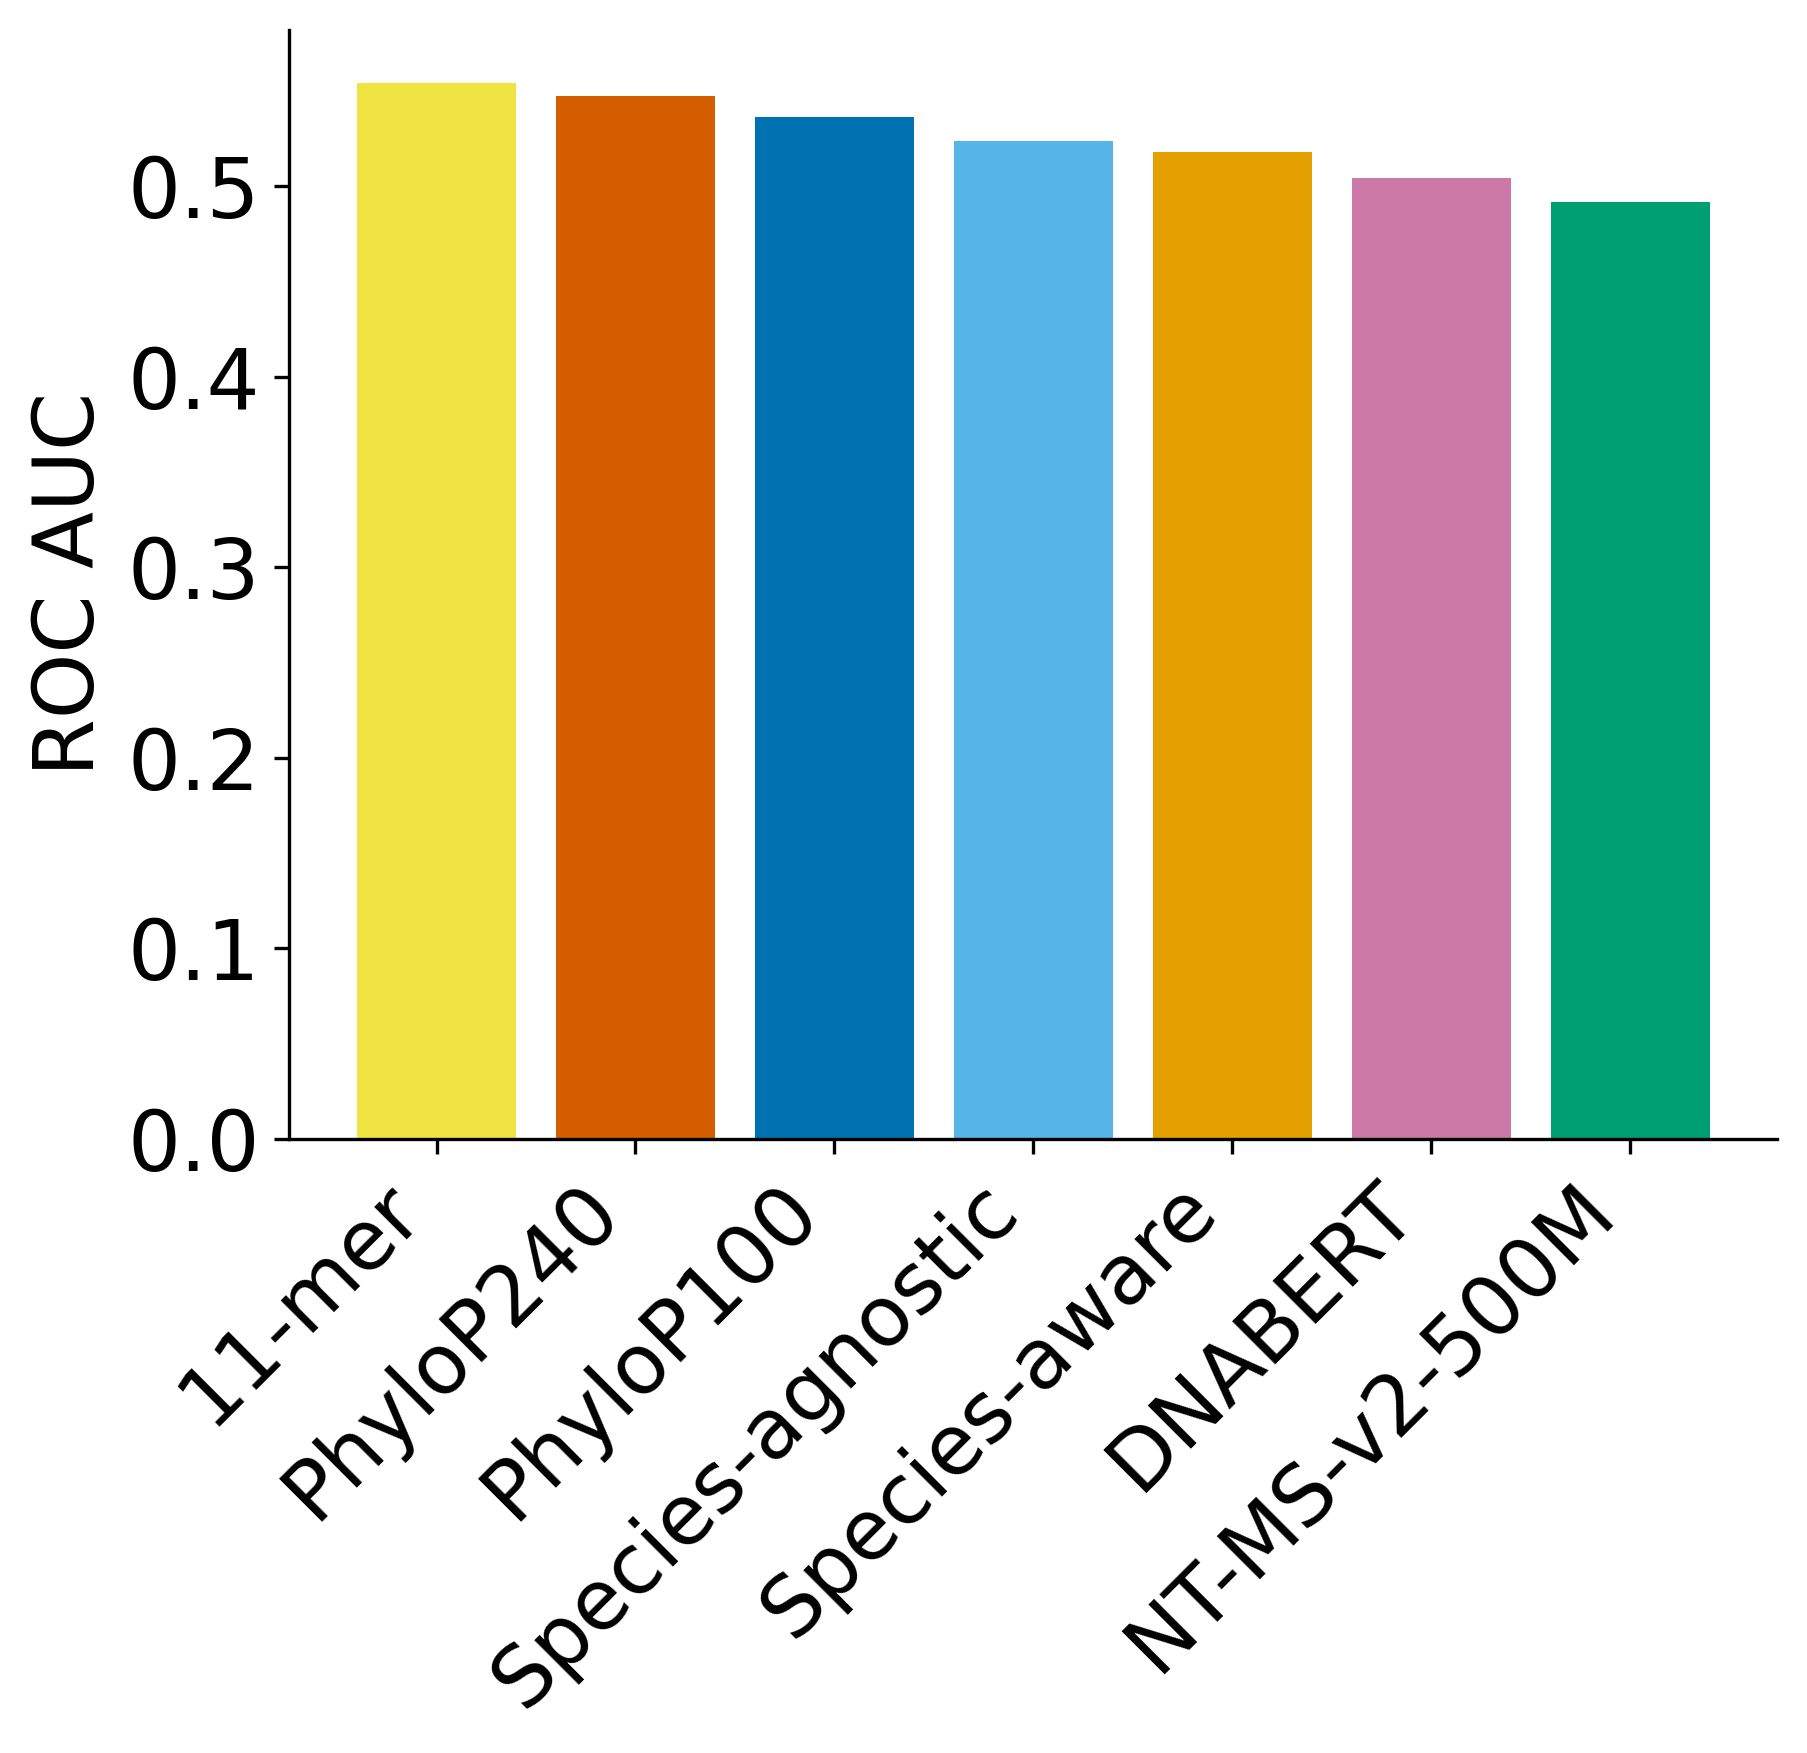

In [163]:
fig, ax = plt.subplots(dpi=300)

df = odds_ratios.sort_values(by='roc_auc', ascending=False)

ax.bar(df.index, df.roc_auc, color=df.index.map(model_colors))
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)